In [225]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline

In [226]:
message = pd.read_csv('C:/Users/nikhi/Desktop/cps/project/spam/spam.csv', encoding='latin-1')

In [227]:
message1 = [line.rstrip() for line in open('C:/Users/nikhi/Desktop/cps/project/spam/spam.csv')]

In [228]:
message.tail()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN
5571,ham,Rofl. Its true to its name,NaN,NaN,NaN


In [229]:
message = message.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
message = message.rename(columns = {'v1':'label','v2':'message'})
message.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [231]:
message.tail()

,label,message,length
5567,1,This is the 2nd time we have tried 2 contact u...,161
5568,0,Will Ì_ b going to esplanade fr home?,37
5569,0,"Pity, * was in mood for that. So...any other s...",57
5570,0,The guy did some bitching but I acted like i'd...,125
5571,0,Rofl. Its true to its name,26


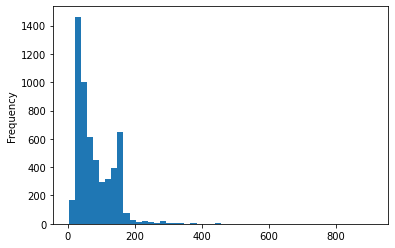

In [232]:
#visualize the distribution of length
message['length'].plot(bins=50,kind='hist')

# Pre-processing 

We will be using bag-of-words approach, where each unique word in a text will be represented by one number.
Steps to convert raw messages(sequence of characters) into vectors (sequence of numbers):
          1. Split a message into it individual words and return a list
          2. Remove very common words('the','a',etc..)

In [233]:
def text_process(mess):
    nopunc = [char for char in mess if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    return [word for word in nopunc.split() if word.lower() not in stopwords.words('english')]

In [280]:
from textblob import TextBlob

def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

message['message'].head().apply(split_into_lemmas)

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, 2, a, wkly, comp, to, win, f...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, do, n't, think, he, go, to, usf, he, ...
Name: message, dtype: object

In [234]:
message['message'].tail(10).apply(text_process)
# message.head()

5562    [Ok, lor, Sony, ericsson, salesman, ask, shuhu...
5563                             [Ard, 6, like, dat, lor]
5564        [dont, wait, til, least, wednesday, see, get]
5565                                           [Huh, lei]
5566    [REMINDER, O2, get, 250, pounds, free, call, c...
5567    [2nd, time, tried, 2, contact, u, U, å£750, Po...
5568                   [Ì, b, going, esplanade, fr, home]
5569                     [Pity, mood, Soany, suggestions]
5570    [guy, bitching, acted, like, id, interested, b...
5571                                   [Rofl, true, name]
Name: message, dtype: object

# Continuing Normalization

Lot of ways to continue normalizing this text.
Such as Stemming or distinguishing by part of speech.
NLTK has lots of build-in tools and great documentation. it doest work well for text-messages due to abbreviations used

# Vectorization

messages as list of tokens (also known as lemmas) and now we need to convert each msg into vectors that ml model can understand.

three steps using bag-of-words model:
1. Count how many times does a word occur in each message (term frequency)
2. weight the counts, so that frequent tokens get lower weight (inverse document frequency)
3. Normalize the vectors to unit length, to abstract from the original text length (l2 norm) 


Each vector will have many dimensions as they are unique words in the SMS corpus. 

SciKit Learn's CountVectorizer will convert a collection of text documents to a matrix of token counts.

2 - Dimensional Matrix
One - Dimension would be entire vocabulary (1 row per word) and other dimension are the actual documents, in this case a column per text message.  

In [235]:
from sklearn.feature_extraction.text import CountVectorizer

In [236]:
bow_transformer = CountVectorizer(analyzer= text_process).fit(message['message'])
print(len(bow_transformer.vocabulary_))

11304


In [237]:
#transform
message_bow = bow_transformer.transform(message['message'])

In [238]:
print('shape of the Sparse Matrix:', message_bow.shape)
print('Non-zero occurences:', message_bow.nnz)

shape of the Sparse Matrix: (5572, 11304)
Non-zero occurences: 50193


The term and normalization can be done with TF-IDF using scikit-learn's TfidfTransformer.

# TF-IDF
Term frequency - inverse document frequency. often used in information retrieval and text mining.
1. Weight is a statistical measure used to evaluate how imp a word is to a document in a collection or corpus
2. Imp increase proportionally to the no of times a word appears in the document but is offset by the freq of the word in the corpus
3. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

## TF : Term Frequency:

Measures how freq a term occurs in a document. Every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. 

Term freq is often divided by the document length (i.e. total no of terms in the document) as a wy of normalization:

TF(t) = (No of times term t appears in a document)/ (To no of terms in the document)

## IDF : Inverse Document Frequency:

Measure how important a term is.  While calculating TF, all terms are considered equally imp. 

However it is known that certain terms, such as 'is', 'of', 'the' may appear a lot of times but have little imp. 

Thus we need to weigth down the freq terms while scale up the rare ones, by computing the following:

IDF(t) = log_e(Total no of documents / No of documents with term t in it)


In [239]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(message_bow)
message_tfidf = tfidf_transformer.transform(message_bow)
print(message_tfidf.shape)

(5572, 11304)


# Data Pipeline

We will be using Sklearn's pipeline capabiliter to store a pipeline of workflow.

This allows us to set up all the transformations that we will do to the data for future use. 

In [296]:
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
   ( 'bow',CountVectorizer(analyzer=text_process)),
    ('tfidf',TfidfTransformer()),
    ('classifier',MultinomialNB()),
])

# Training a Model

With messages represented as vectors, we can finally train our spam/ham classifier.
We will be using Naive Bayes classifier algorithm to build spam classifier

In [241]:
from sklearn.naive_bayes import MultinomialNB

In [242]:
#split the dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(message['message'], message['label'],test_size=0.1, random_state=42)
print(len(X_train), len(X_test))

4457 1115


In [297]:
#fit the train dataset in pipeline
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000176838A5AF8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [298]:
predictions = pipeline.predict(X_test)

In [299]:
y_test.value_counts()

0    965
1    150
Name: label, dtype: int64

In [300]:
from sklearn.metrics import classification_report,confusion_matrix, f1_score
print(classification_report(predictions,y_test))
print(confusion_matrix(predictions,y_test))
print(f1_score(predictions,y_test))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1003
           1       0.75      1.00      0.85       112

    accuracy                           0.97      1115
   macro avg       0.87      0.98      0.92      1115
weighted avg       0.97      0.97      0.97      1115

[[965  38]
 [  0 112]]
0.8549618320610688


In [301]:
print(f1_score(predictions,y_test))

0.8549618320610688


In [204]:
from sklearn.externals import joblib
joblib.dump(pipeline, 'spam.pkl')

['spam.pkl']

In [205]:
from flask import Flask,render_template,url_for,request
app = Flask(__name__)

In [286]:
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier

class MyClassifier(BaseEstimator):

    def __init__(self, classifier_type: str = 'rf'):
        """
        A Custome BaseEstimator that can switch between classifiers.
        :param classifier_type: string - The switch for different classifiers
        """
        self.classifier_type = classifier_type


    def fit(self, X, y=None):
        if self.classifier_type == 'rf':
            self.classifier_ = RandomForestClassifier(n_estimators=10)
        elif self.classifier_type == 'MultinomialNB':
            self.classifier_ = MultinomialNB()
        else:
            raise ValueError('Unkown classifier type.')

        self.classifier_.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.classifier_.predict(X)

In [287]:
pipeline1 = Pipeline([
    ('bow',CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf',TfidfTransformer()),
    ('clf', MyClassifier())
])

In [290]:
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score, precision_score, recall_score

parameter_space = {
    'clf__classifier_type': ['rf', 'MultinomialNB']
}
scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
        }

from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipeline1 , parameter_space,verbose=1,cv=3,scoring=scorers,refit="precision_score")
search.fit(X_train, y_train)

print('Best model:\n', search.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   19.1s finished


Best model:
 {'clf__classifier_type': 'MultinomialNB'}


In [291]:
predictions1 = search.predict(X_test)

In [292]:
print(classification_report(predictions1,y_test))
print(confusion_matrix(predictions1,y_test))
print(f1_score(predictions1,y_test))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98      1011
           1       0.69      1.00      0.82       104

    accuracy                           0.96      1115
   macro avg       0.85      0.98      0.90      1115
weighted avg       0.97      0.96      0.96      1115

[[965  46]
 [  0 104]]
0.8188976377952756


In [304]:
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import StratifiedKFold
# svc = svm.SVC()
pipeline_svm = Pipeline([
    ('bow',CountVectorizer(analyzer=split_into_lemmas)),
    ('tfidf', TfidfTransformer()),
    ('classifier', svm.SVC()),  # <== change here
])

# pipeline parameters to automatically explore and tune
param_svm = [
  {'classifier__C': [1, 10, 100, 1000], 'classifier__kernel': ['linear']},
  {'classifier__C': [1, 10, 100, 1000], 'classifier__gamma': [0.001, 0.0001], 'classifier__kernel': ['rbf']},
]

grid_svm = GridSearchCV(
    pipeline_svm,  # pipeline from above
    param_grid=param_svm,  # parameters to tune via cross validation
    refit=True,  # fit using all data, on the best detected classifier
     # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(n_splits=5),  # what type of cross validation to use
)

In [305]:
%time svm_detector = grid_svm.fit(X_train, y_train) 

Wall time: 5min 50s


In [306]:
predictions2 = svm_detector.predict(X_test)

In [307]:
print(classification_report(predictions2,y_test))
print(confusion_matrix(predictions2,y_test))
print(f1_score(predictions2, y_test))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       978
           1       0.91      1.00      0.95       137

    accuracy                           0.99      1115
   macro avg       0.96      0.99      0.97      1115
weighted avg       0.99      0.99      0.99      1115

[[965  13]
 [  0 137]]
0.9547038327526133


   precision    recall  f1-score   support

           0       1.00      0.99      0.99       975
           1       0.91      0.97      0.94       140

    accuracy                           0.98      1115
   macro avg       0.95      0.98      0.96      1115
weighted avg       0.98      0.98      0.98      1115

[[961  14]
 [  4 136]]
0.9379310344827586

In [268]:
grid_svm.best_estimator_

Pipeline(memory=None,
         steps=[('bow',
                 CountVectorizer(analyzer=<function text_process at 0x00000176838A5AF8>,
                                 binary=False, decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w...
                                 tokenizer=None, vocabulary=None)),
                ('tfidf',
                 TfidfTransformer(norm='l2', smooth_idf=True,
                                  sublinear_tf=False, use_idf=True)),
                ('classifier',
                 SVC(C=1000, cache_size=200, class_weight=None, coef0=0.0,
                     decision_functi

In [308]:
from sklearn.externals import joblib
joblib.dump(grid_svm.best_estimator_, 'spam.pkl')

['spam.pkl']

In [313]:
!pip install sklearn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.21.3.


In [310]:
print(svm_detector.predict(["Hi mom, how are you?"])[0])
print(svm_detector.predict(["WINNER! Credit for free!"])[0])

0
1


In [294]:
print(search.predict_proba(["Hi mom, how are you?"])[0])
print(search.predict_proba(["WINNER! Credit for free!"])[0])

AttributeError: 'MyClassifier' object has no attribute 'predict_proba'